Uday Singh (22B1262) \
Ankit Maurya (22B1266) \
Aditya Bhadoria (22B1247)

Github - https://github.com/Uday1Singh/EE782-Sentiment-Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torchaudio
import numpy as np
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import os
from tqdm import tqdm
import pickle
import joblib

In [3]:
# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    # Paths - UPDATE THESE TO YOUR PATHS
    SPEECH_DIR = r'/content/drive/MyDrive/audio_speech_actors_01-24'
    # SONG_DIR = r'C:\Users\pashu\OneDrive\Desktop\non-academics\soc\speech_recong_project\Audio_Song_Actors_01-24'

    # Model
    PRETRAINED_MODEL = "facebook/wav2vec2-base"

    # RAVDESS Emotion Mapping (based on filename position 7)
    # Position 7 in RAVDESS filename indicates emotion
    EMOTION_MAP = {
        '1': 'neutral',
        '2': 'calm',
        '3': 'happy',
        '4': 'sad',
        '5': 'angry',
        '6': 'fearful',
        '7': 'disgusted',
        '8': 'surprised'
    }

    # Training
    BATCH_SIZE = 8
    LEARNING_RATE = 3e-5
    NUM_EPOCHS = 15
    SAMPLE_RATE = 16000
    MAX_AUDIO_LENGTH = 5  # seconds
    TEST_SIZE = 0.2

    # Save paths
    MODEL_SAVE_PATH = 'emotion_transformer_model.pth'
    LABEL_ENCODER_PATH = 'label_encoder_transformer.pkl'
    PROCESSOR_PATH = 'wav2vec2_processor'

config = Config()

In [4]:
# ============================================================================
# DATASET CLASS FOR RAVDESS (ROBUST FIX)
# ============================================================================
import librosa
import numpy as np
from torch.utils.data import Dataset
import torch

class RAVDESSDataset(Dataset):
    """Dataset for RAVDESS audio files with Transformer preprocessing"""

    def __init__(self, file_paths, labels, processor, max_length_seconds=5):
        self.file_paths = file_paths
        self.labels = labels
        self.processor = processor
        self.max_samples = int(max_length_seconds * config.SAMPLE_RATE)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            # 1. LOAD AUDIO WITH LIBROSA
            #    More robust than torchaudio for Colab/Drive
            waveform, sr = librosa.load(file_path, sr=config.SAMPLE_RATE, mono=True)

            # 2. PAD OR TRUNCATE
            if len(waveform) < self.max_samples:
                padding = self.max_samples - len(waveform)
                waveform = np.pad(waveform, (0, padding), 'constant')
            else:
                waveform = waveform[:self.max_samples]

            # 3. PROCESS WITH WAV2VEC2
            inputs = self.processor(
                waveform,
                sampling_rate=config.SAMPLE_RATE,
                return_tensors="pt",
                padding=True # Ensure mask is created
            )

            # 4. ROBUST MASK RETRIEVAL
            input_values = inputs['input_values']
            if 'attention_mask' in inputs:
                attention_mask = inputs['attention_mask']
            else:
                # Fallback if processor doesn't return mask
                attention_mask = torch.ones_like(input_values)

            return {
                'input_values': input_values.squeeze(),
                'attention_mask': attention_mask.squeeze(),
                'labels': torch.tensor(label, dtype=torch.long)
            }

        except Exception as e:
            # PRINT ERROR BUT DO NOT CRASH
            print(f"Error loading {file_path}: {e}")

            # Fallback: return dummy zeros
            dummy_audio = np.zeros(self.max_samples)
            inputs = self.processor(
                dummy_audio,
                sampling_rate=config.SAMPLE_RATE,
                return_tensors="pt",
                padding=True
            )

            # Safely get/create mask for dummy data
            input_values = inputs['input_values']
            if 'attention_mask' in inputs:
                attention_mask = inputs['attention_mask']
            else:
                attention_mask = torch.ones_like(input_values)

            return {
                'input_values': input_values.squeeze(),
                'attention_mask': attention_mask.squeeze(),
                'labels': torch.tensor(0, dtype=torch.long)
            }

In [5]:

# ============================================================================
# LOAD RAVDESS DATA (YOUR FORMAT)
# ============================================================================

def load_ravdess_data():
    """Load data from your RAVDESS folders using os.walk for robust traversal"""

    file_paths = []
    emotions = []

    # Load from both Speech and Song directories
    for directory in [config.SPEECH_DIR]:
        if not os.path.exists(directory):
            print(f"Warning: Directory not found: {directory}")
            continue

        print(f"Loading from: {directory}")

        # Use os.walk to recursively search for files in all subdirectories
        for root, _, filenames in os.walk(directory):
            for filename in filenames:
                # Check for .wav files (case-insensitive for robustness)
                if filename.lower().endswith('.wav'):
                    file_path = os.path.join(root, filename)

                    # Extract emotion from filename (position 7)
                    # RAVDESS format: 03-01-06-01-02-01-12.wav
                    try:
                        # Position 3 (0-indexed: 2) is the emotion code (e.g., '06')
                        emotion_code = filename.split('-')[2]

                        # Convert '01'/'08' to '1'/'8' for correct dictionary lookup
                        emotion_code_key = str(int(emotion_code))

                        emotion = config.EMOTION_MAP.get(emotion_code_key, 'unknown')

                        if emotion != 'unknown':
                            file_paths.append(file_path)
                            emotions.append(emotion)
                    except:
                        print(f"Could not parse filename: {filename}")

    print(f"\nTotal files loaded: {len(file_paths)}")
    print(f"Emotion distribution:")
    for emotion in set(emotions):
        count = emotions.count(emotion)
        print(f"  {emotion}: {count}")

    return file_paths, emotions

In [6]:
# ============================================================================
# TRANSFORMER MODEL (UNCHANGED)
# ============================================================================

class EmotionTransformer(nn.Module):
    """Transformer model for emotion recognition"""

    def __init__(self, num_emotions=8):
        super(EmotionTransformer, self).__init__()

        # Load Wav2Vec2
        self.wav2vec2 = Wav2Vec2Model.from_pretrained(config.PRETRAINED_MODEL)

        # ========================================================================
        # THE UPDATE: UNFREEZE THE TRANSFORMER LAYERS
        # ========================================================================

        # Instead of freezing everything, we ONLY freeze the feature extractor.
        # The feature extractor converts raw audio to latent features. It is fragile
        # and usually kept frozen during fine-tuning.
        self.wav2vec2.feature_extractor.requires_grad_(False)

        # The rest of the model (the Transformer encoder) remains UNFROZEN (requires_grad=True).
        # This allows it to learn "How" you are speaking (emotions), not just "What" (words).

        # (Deleted the loop that set everything to False)
        # ========================================================================

        hidden_size = self.wav2vec2.config.hidden_size

        # Attention pooling (Unchanged)
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )

        # Classification head (Unchanged)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_emotions)
        )

    def forward(self, input_values, attention_mask=None):
        # Extract features
        outputs = self.wav2vec2(input_values, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        # Attention pooling
        attention_weights = self.attention(hidden_states)
        pooled = torch.sum(hidden_states * attention_weights, dim=1)

        # Classify
        logits = self.classifier(pooled)
        return logits
# ============================================================================
# TRAINING FUNCTION (FIXED: num_workers=0)
# ============================================================================

def train_model():
    """Main training function"""

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\nUsing device: {device}")

    # Load processor
    print("\nLoading Wav2Vec2 processor...")
    processor = Wav2Vec2Processor.from_pretrained(config.PRETRAINED_MODEL)

    # Load data
    print("\nLoading RAVDESS data...")
    file_paths, emotions = load_ravdess_data()

    if len(file_paths) == 0:
        print("ERROR: No data loaded! Check your directory paths.")
        return

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(emotions)

    # Save label encoder
    with open(config.LABEL_ENCODER_PATH, 'wb') as f:
        pickle.dump(label_encoder, f)

    print(f"\nEmotions: {label_encoder.classes_}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        file_paths, labels_encoded,
        test_size=config.TEST_SIZE,
        random_state=42,
        stratify=labels_encoded
    )

    print(f"\nTrain samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")

    # Create datasets
    train_dataset = RAVDESSDataset(X_train, y_train, processor)
    test_dataset = RAVDESSDataset(X_test, y_test, processor)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=0 # SET TO 0 FOR STABLE GOOGLE DRIVE I/O
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=0 # SET TO 0 FOR STABLE GOOGLE DRIVE I/O
    )

    # Initialize model
    print("\nInitializing Transformer model...")
    num_emotions = len(label_encoder.classes_)
    model = EmotionTransformer(num_emotions=num_emotions).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)

    # Training loop
    print(f"\n{'='*80}")
    print("STARTING TRAINING")
    print(f"{'='*80}\n")

    best_acc = 0.0

    for epoch in range(1, config.NUM_EPOCHS + 1):
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch}/{config.NUM_EPOCHS} [Train]')
        for batch in pbar:
            input_values = batch['input_values'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            logits = model(input_values, attention_mask)
            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * train_correct / train_total:.2f}%'
            })

        train_acc = 100 * train_correct / train_total

        # Test
        model.eval()
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for batch in test_loader:
                input_values = batch['input_values'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_values, attention_mask)
                _, predicted = torch.max(logits, 1)

                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_acc = 100 * test_correct / test_total

        print(f'\nEpoch {epoch}:')
        print(f'  Train Accuracy: {train_acc:.2f}%')
        print(f'  Test Accuracy: {test_acc:.2f}%')

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_acc': test_acc,
                'label_encoder': label_encoder
            }, config.MODEL_SAVE_PATH)
            print(f'  ✓ Best model saved! (Accuracy: {test_acc:.2f}%)')

        print(f"{'='*80}")

    print(f"\n{'='*80}")
    print(f"TRAINING COMPLETE!")
    print(f"Best Test Accuracy: {best_acc:.2f}%")
    print(f"Your old model: 74.75%")
    print(f"Improvement: +{best_acc - 74.75:.2f}%")
    print(f"{'='*80}\n")

In [7]:
# ============================================================================
# INFERENCE (FOR YOUR GUI)
# ============================================================================

def load_trained_model():
    """Load trained model for inference"""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load checkpoint
    checkpoint = torch.load(config.MODEL_SAVE_PATH, map_location=device)
    label_encoder = checkpoint['label_encoder']

    # Initialize model
    model = EmotionTransformer(num_emotions=len(label_encoder.classes_))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Load processor
    processor = Wav2Vec2Processor.from_pretrained(config.PRETRAINED_MODEL)

    return model, processor, label_encoder, device

def predict_emotion_transformer(audio, model, processor, label_encoder, device):
    """
    Predict emotion from audio array
    Compatible with your existing GUI code

    Args:
        audio: numpy array of audio samples
        model: trained model
        processor: Wav2Vec2 processor
        label_encoder: fitted label encoder
        device: torch device

    Returns:
        emotion: predicted emotion string
        confidence: confidence score
    """

    # Convert to mono if stereo
    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    # Process audio
    inputs = processor(
        audio,
        sampling_rate=config.SAMPLE_RATE,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs.input_values.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Predict
    with torch.no_grad():
        logits = model(input_values, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_idx].item()

    emotion = label_encoder.inverse_transform([predicted_idx])[0]

    return emotion, confidence

# ============================================================================
# GUI INTEGRATION CODE
# ============================================================================

def create_gui_with_transformer():
    """
    Updated GUI code that uses Transformer model
    Drop-in replacement for your existing GUI
    """

    import tkinter as tk
    from tkinter import messagebox
    import sounddevice as sd
    import librosa

    # Load model once
    print("Loading Transformer model...")
    model, processor, label_encoder, device = load_trained_model()
    print("Model loaded successfully!")

    def record_audio(duration=5, fs=16000):  # Changed to 16kHz for Wav2Vec2
        print("Recording...")
        audio = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float32')
        sd.wait()
        print("Recording complete.")
        return audio.flatten()

    def predict_emotion():
        try:
            # Record audio
            audio = record_audio(duration=5)

            # Resample if needed (ensure 16kHz)
            if len(audio) != 5 * 16000:
                audio = librosa.resample(audio, orig_sr=44100, target_sr=16000)

            # Predict
            emotion, confidence = predict_emotion_transformer(
                audio, model, processor, label_encoder, device
            )

            messagebox.showinfo(
                "Predicted Emotion",
                f'Emotion: {emotion.capitalize()}\n'
                f'Confidence: {confidence*100:.1f}%'
            )

        except Exception as e:
            messagebox.showerror("Error", f"Prediction failed: {str(e)}")

    # Create GUI
    app = tk.Tk()
    app.title("Transformer Emotion Detection")
    app.geometry("350x200")

    title_label = tk.Label(
        app,
        text="Speech Emotion Recognition\n(Transformer Model)",
        font=("Arial", 12, "bold")
    )
    title_label.pack(pady=20)

    record_button = tk.Button(
        app,
        text="🎤 Record and Predict Emotion",
        command=predict_emotion,
        height=2,
        width=30,
        bg="#4CAF50",
        fg="white",
        font=("Arial", 10, "bold")
    )
    record_button.pack(pady=20)

    info_label = tk.Label(
        app,
        text="Speak for 5 seconds when recording starts",
        font=("Arial", 9),
        fg="gray"
    )
    info_label.pack()

    app.mainloop()

In [8]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == '__main__':
    import argparse

    parser = argparse.ArgumentParser(description='Transformer Speech Emotion Recognition')
    parser.add_argument('--mode', type=str, default='train',
                       choices=['train', 'gui'],
                       help='Mode: train model or run GUI')

    # FIX FOR JUPYTER NOTEBOOK
    args, unknown = parser.parse_known_args()

    if args.mode == 'train':
        print("="*80)
        print("UPGRADING YOUR MODEL TO TRANSFORMERS")
        print("="*80)
        train_model()

    elif args.mode == 'gui':
        create_gui_with_transformer()


UPGRADING YOUR MODEL TO TRANSFORMERS

Using device: cuda

Loading Wav2Vec2 processor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]


Loading RAVDESS data...
Loading from: /content/drive/MyDrive/audio_speech_actors_01-24

Total files loaded: 1440
Emotion distribution:
  fearful: 192
  neutral: 96
  sad: 192
  calm: 192
  surprised: 192
  angry: 192
  disgusted: 192
  happy: 192

Emotions: ['angry' 'calm' 'disgusted' 'fearful' 'happy' 'neutral' 'sad' 'surprised']

Train samples: 1152
Test samples: 288

Initializing Transformer model...


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]


STARTING TRAINING



model.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

Epoch 1/15 [Train]: 100%|██████████| 144/144 [08:10<00:00,  3.41s/it, loss=1.7914, acc=21.18%]



Epoch 1:
  Train Accuracy: 21.18%
  Test Accuracy: 34.38%
  ✓ Best model saved! (Accuracy: 34.38%)


Epoch 2/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.31it/s, loss=1.4572, acc=34.29%]



Epoch 2:
  Train Accuracy: 34.29%
  Test Accuracy: 50.00%
  ✓ Best model saved! (Accuracy: 50.00%)


Epoch 3/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=1.4794, acc=46.35%]



Epoch 3:
  Train Accuracy: 46.35%
  Test Accuracy: 60.42%
  ✓ Best model saved! (Accuracy: 60.42%)


Epoch 4/15 [Train]: 100%|██████████| 144/144 [01:50<00:00,  1.31it/s, loss=0.9374, acc=55.38%]



Epoch 4:
  Train Accuracy: 55.38%
  Test Accuracy: 53.82%


Epoch 5/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.9666, acc=61.98%]



Epoch 5:
  Train Accuracy: 61.98%
  Test Accuracy: 67.71%
  ✓ Best model saved! (Accuracy: 67.71%)


Epoch 6/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.7402, acc=74.31%]



Epoch 6:
  Train Accuracy: 74.31%
  Test Accuracy: 75.69%
  ✓ Best model saved! (Accuracy: 75.69%)


Epoch 7/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.31it/s, loss=0.4621, acc=78.82%]



Epoch 7:
  Train Accuracy: 78.82%
  Test Accuracy: 79.17%
  ✓ Best model saved! (Accuracy: 79.17%)


Epoch 8/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.4132, acc=81.51%]



Epoch 8:
  Train Accuracy: 81.51%
  Test Accuracy: 75.00%


Epoch 9/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.1512, acc=83.33%]



Epoch 9:
  Train Accuracy: 83.33%
  Test Accuracy: 85.42%
  ✓ Best model saved! (Accuracy: 85.42%)


Epoch 10/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.3579, acc=85.42%]



Epoch 10:
  Train Accuracy: 85.42%
  Test Accuracy: 81.25%


Epoch 11/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.1734, acc=87.50%]



Epoch 11:
  Train Accuracy: 87.50%
  Test Accuracy: 83.68%


Epoch 12/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.1042, acc=92.88%]



Epoch 12:
  Train Accuracy: 92.88%
  Test Accuracy: 86.81%
  ✓ Best model saved! (Accuracy: 86.81%)


Epoch 13/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.1668, acc=90.28%]



Epoch 13:
  Train Accuracy: 90.28%
  Test Accuracy: 74.65%


Epoch 14/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.0635, acc=90.36%]



Epoch 14:
  Train Accuracy: 90.36%
  Test Accuracy: 87.50%
  ✓ Best model saved! (Accuracy: 87.50%)


Epoch 15/15 [Train]: 100%|██████████| 144/144 [01:49<00:00,  1.32it/s, loss=0.1031, acc=92.71%]



Epoch 15:
  Train Accuracy: 92.71%
  Test Accuracy: 79.86%

TRAINING COMPLETE!
Best Test Accuracy: 87.50%
Your old model: 74.75%
Improvement: +12.75%



In [12]:
import torch
import torchaudio
import librosa
import numpy as np
import os
from transformers import Wav2Vec2Processor
from torch import nn
from transformers import Wav2Vec2Model

# --- Configuration (Necessary Imports for this block) ---
# Assuming 'config' is available and EmotionTransformer is defined.
# --------------------------------------------------------

# --------------------------------------------------------
# 1. FIXED MODEL LOADING FUNCTION (Cell 8)
# --------------------------------------------------------
def load_trained_model():
    """Load trained model for inference, applying the weights_only=False fix."""

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # FIX: Add weights_only=False for safe loading of LabelEncoder
    # Note: Assumes config.MODEL_SAVE_PATH exists and has been saved by Cell 7.
    checkpoint = torch.load(config.MODEL_SAVE_PATH, map_location=device, weights_only=False)
    label_encoder = checkpoint['label_encoder']

    # Initialize model (assumes EmotionTransformer is defined in runtime)
    num_emotions = len(label_encoder.classes_)
    model = EmotionTransformer(num_emotions=num_emotions)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    processor = Wav2Vec2Processor.from_pretrained(config.PRETRAINED_MODEL)

    return model, processor, label_encoder, device

# --------------------------------------------------------
# 2. PREDICTION FUNCTION (Cell 8) - FINAL FIX: Safe Mask Access
# --------------------------------------------------------
def predict_emotion_transformer(audio, model, processor, label_encoder, device):
    """Predict emotion from audio array using the loaded model."""

    if audio.ndim > 1:
        audio = audio.mean(axis=1)

    inputs = processor(
        audio,
        sampling_rate=config.SAMPLE_RATE,
        return_tensors="pt",
        padding=True
    )

    input_values = inputs['input_values'].to(device)

    # --- FINAL FIX: Safely retrieve attention_mask or create a fallback ---
    attention_mask = inputs.get('attention_mask')
    if attention_mask is None:
        # If mask is missing, assume full attention (all ones) for the input length
        attention_mask = torch.ones_like(input_values)
    else:
        attention_mask = attention_mask.to(device)
    # ----------------------------------------------------------------------

    with torch.no_grad():
        logits = model(input_values, attention_mask)
        probabilities = torch.softmax(logits, dim=1)
        predicted_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_idx].item()

    emotion = label_encoder.inverse_transform([predicted_idx])[0]

    return emotion, confidence

# --------------------------------------------------------
# 3. EXECUTION BLOCK
# --------------------------------------------------------

# Load the trained model components
try:
    model, processor, label_encoder, device = load_trained_model()
    print(f"Model successfully loaded and ready on device: {device}")
except Exception as e:
    print(f"FATAL ERROR: Failed to load trained model. Details: {e}")
    model = None


if model is not None:
    # NOTE: You must replace this path with the actual location of one of your .wav files.
    SAMPLE_AUDIO_PATH = "/content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav"

    print(f"\nTesting model with sample file: {SAMPLE_AUDIO_PATH}")

    try:
        # Load and preprocess the audio file using LIBROSA
        audio_data, sr = librosa.load(
            SAMPLE_AUDIO_PATH,
            sr=config.SAMPLE_RATE,
            mono=True
        )

        # Run prediction
        emotion, confidence = predict_emotion_transformer(
            audio_data, model, processor, label_encoder, device
        )

        print("-" * 30)
        print("PREDICTION RESULT:")
        print(f"File: {os.path.basename(SAMPLE_AUDIO_PATH)}")
        print(f"Predicted Emotion: {emotion.upper()}")
        print(f"Confidence: {confidence * 100:.2f}%")
        print("-" * 30)

    except FileNotFoundError:
        print(f"\nERROR: File not found at {SAMPLE_AUDIO_PATH}")
    except Exception as e:
        # If this still fails, it's likely a memory or deep PyTorch error
        print(f"\nFATAL INFERENCE ERROR:")
        print(f"Exception Type: {type(e).__name__}")
        print(f"Error Message: {e}")
        print("-" * 30)
        print("A critical error occurred during the prediction process.")

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Model successfully loaded and ready on device: cuda

Testing model with sample file: /content/drive/MyDrive/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
------------------------------
PREDICTION RESULT:
File: 03-01-01-01-01-01-01.wav
Predicted Emotion: NEUTRAL
Confidence: 60.37%
------------------------------


In [16]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def generate_report_graphs(model, test_loader, device, label_encoder):
    """
    Generates Confusion Matrix and Class-wise Performance Report
    """
    model.eval()
    all_preds = []
    all_labels = []

    print("Running inference on test set... (This might take a minute)")

    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            # Safe mask retrieval
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
            else:
                attention_mask = torch.ones_like(input_values).to(device)

            labels = batch['labels'].to(device)

            logits = model(input_values, attention_mask)
            _, predicted = torch.max(logits, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Get Class Names
    class_names = label_encoder.classes_

    # ------------------------------------------
    # 1. CONFUSION MATRIX
    # ------------------------------------------
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
    plt.title('Confusion Matrix: Where does the model fail?', fontsize=14)
    plt.xlabel('Predicted Emotion', fontsize=12)
    plt.ylabel('Actual Emotion', fontsize=12)
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # ------------------------------------------
    # 2. CLASSIFICATION REPORT (BAR CHART)
    # ------------------------------------------
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()

    # Filter out 'accuracy', 'macro avg', 'weighted avg' rows to just show classes
    df_classes = df.iloc[:-3]

    plt.figure(figsize=(12, 6))
    # Plotting F1-Score
    bars = sns.barplot(x=df_classes.index, y=df_classes['f1-score'], palette='viridis')

    plt.title('Performance by Emotion (F1-Score)', fontsize=14)
    plt.ylabel('F1 Score (Higher is Better)', fontsize=12)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylim(0, 1.05)

    # Add numbers on top of bars
    for i, v in enumerate(df_classes['f1-score']):
        bars.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('emotion_performance.png', dpi=300)
    plt.show()

    # Print Text Report for Copy-Pasting
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(all_labels, all_preds, target_names=class_names))


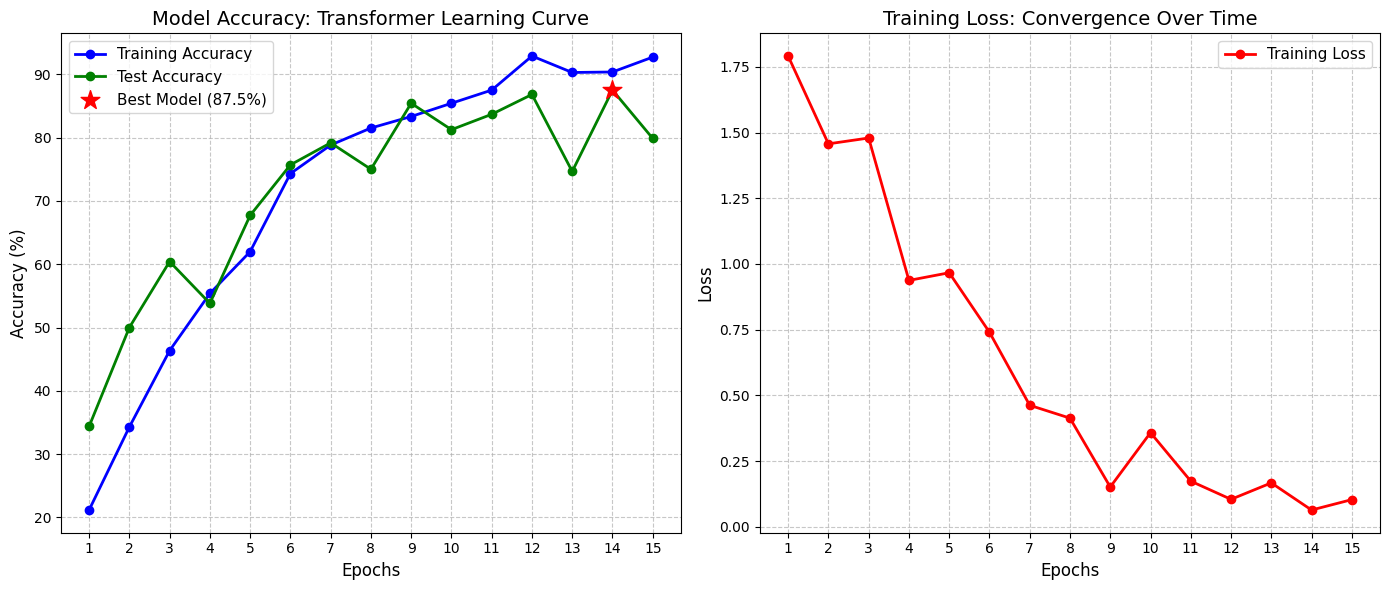

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================================
# 1. DATA FROM LOGS
# ==========================================
epochs = range(1, 16)

train_acc = [21.18, 34.29, 46.35, 55.38, 61.98, 74.31, 78.82, 81.51, 83.33, 85.42, 87.50, 92.88, 90.28, 90.36, 92.71]
test_acc  = [34.38, 50.00, 60.42, 53.82, 67.71, 75.69, 79.17, 75.00, 85.42, 81.25, 83.68, 86.81, 74.65, 87.50, 79.86]
train_loss = [1.7914, 1.4572, 1.4794, 0.9374, 0.9666, 0.7402, 0.4621, 0.4132, 0.1512, 0.3579, 0.1734, 0.1042, 0.1668, 0.0635, 0.1031]

# ==========================================
# 2. PLOTTING
# ==========================================
plt.figure(figsize=(14, 6))

# --- Accuracy Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-o', label='Training Accuracy', linewidth=2)
plt.plot(epochs, test_acc, 'g-o', label='Test Accuracy', linewidth=2)
# Highlight the best epoch (Epoch 14)
plt.scatter(14, 87.50, s=200, c='red', marker='*', zorder=5, label='Best Model (87.5%)')
plt.title('Model Accuracy: Transformer Learning Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)

# --- Loss Plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'r-o', label='Training Loss', linewidth=2)
plt.title('Training Loss: Convergence Over Time', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300) # Saves high-res image for your report
plt.show()

Loading your best saved model...


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Reconstructing Test Set (using random_seed=42)...
Loading from: /content/drive/MyDrive/audio_speech_actors_01-24

Total files loaded: 1440
Emotion distribution:
  fearful: 192
  neutral: 96
  sad: 192
  calm: 192
  surprised: 192
  angry: 192
  disgusted: 192
  happy: 192
Test Loader Ready! (288 samples)
Running inference on test set...


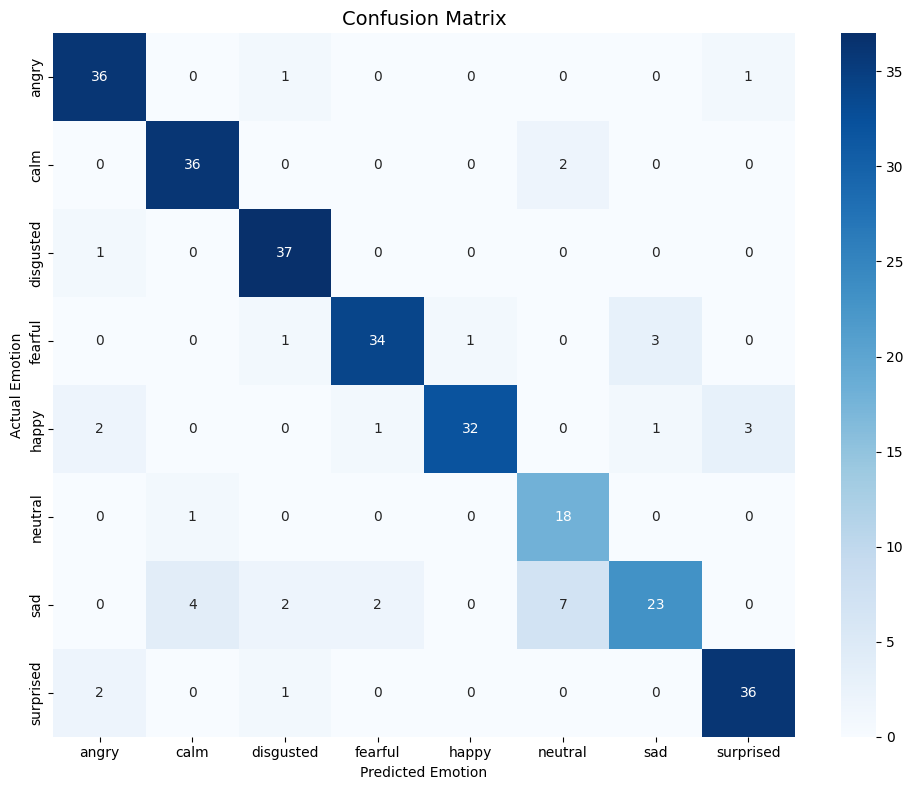

/tmp/ipython-input-4027412081.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=df_classes.index, y=df_classes['f1-score'], palette='viridis')


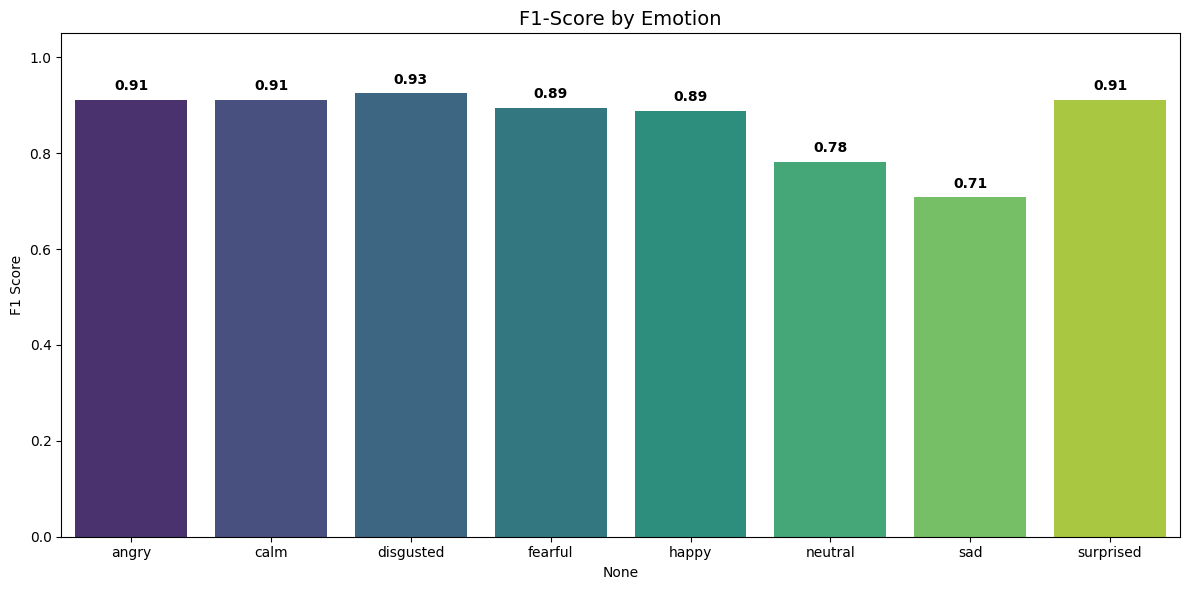


Detailed Report:

              precision    recall  f1-score   support

       angry       0.88      0.95      0.91        38
        calm       0.88      0.95      0.91        38
   disgusted       0.88      0.97      0.93        38
     fearful       0.92      0.87      0.89        39
       happy       0.97      0.82      0.89        39
     neutral       0.67      0.95      0.78        19
         sad       0.85      0.61      0.71        38
   surprised       0.90      0.92      0.91        39

    accuracy                           0.88       288
   macro avg       0.87      0.88      0.87       288
weighted avg       0.88      0.88      0.87       288



In [17]:
# ==============================================================================
# REPAIR BLOCK: Reconstruct Data and Load Model
# ==============================================================================
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# 1. Load the Best Saved Model
print("Loading your best saved model...")
model, processor, label_encoder, device = load_trained_model()

# 2. Re-load Data to reconstruct the Test Split
print("Reconstructing Test Set (using random_seed=42)...")
file_paths, emotions = load_ravdess_data()

# 3. Encode labels using the loaded encoder
labels_encoded = label_encoder.transform(emotions)

# 4. Split exactly as before (random_state=42 is CRITICAL to get the same test set)
X_train, X_test, y_train, y_test = train_test_split(
    file_paths, labels_encoded,
    test_size=config.TEST_SIZE,
    random_state=42,
    stratify=labels_encoded
)

# 5. Re-create Dataset and Loader
test_dataset = RAVDESSDataset(X_test, y_test, processor)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

print(f"Test Loader Ready! ({len(X_test)} samples)")

# ==============================================================================
# NOW GENERATE THE GRAPHS
# ==============================================================================

def generate_report_graphs(model, test_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    print("Running inference on test set...")

    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            # Safe mask retrieval
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
            else:
                attention_mask = torch.ones_like(input_values).to(device)

            labels = batch['labels'].to(device)

            logits = model(input_values, attention_mask)
            _, predicted = torch.max(logits, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Get Class Names
    class_names = label_encoder.classes_

    # --- 1. CONFUSION MATRIX ---
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('Actual Emotion')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # --- 2. CLASSIFICATION REPORT ---
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df_classes = df.iloc[:-3] # Remove average rows

    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=df_classes.index, y=df_classes['f1-score'], palette='viridis')

    plt.title('F1-Score by Emotion', fontsize=14)
    plt.ylabel('F1 Score')
    plt.ylim(0, 1.05)

    # Add numbers
    for i, v in enumerate(df_classes['f1-score']):
        bars.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')

    plt.tight_layout()
    plt.savefig('emotion_performance.png', dpi=300)
    plt.show()

    print("\nDetailed Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

# Run it!
generate_report_graphs(model, test_loader, device, label_encoder)

Calculating probabilities for ROC curves...


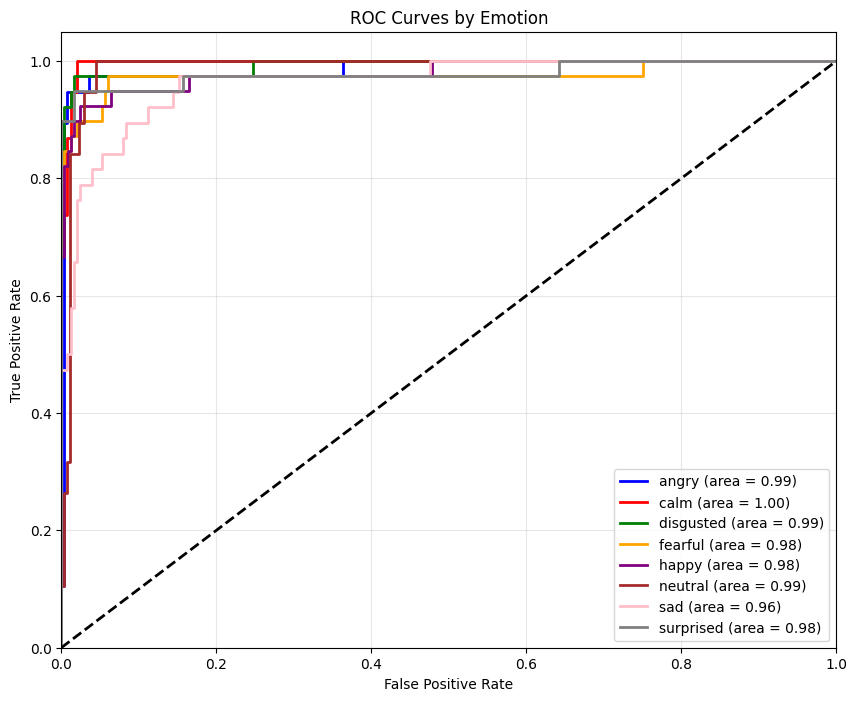

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def plot_roc_curves(model, test_loader, device, label_encoder):
    model.eval()

    # 1. Get Probabilities
    all_probs = []
    all_labels = []

    print("Calculating probabilities for ROC curves...")
    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
            else:
                attention_mask = torch.ones_like(input_values).to(device)

            labels = batch['labels'].to(device)

            # Get Logits -> Softmax
            logits = model(input_values, attention_mask)
            probs = torch.softmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # 2. Binarize labels for One-vs-Rest ROC
    classes = label_encoder.classes_
    n_classes = len(classes)
    y_test_bin = label_binarize(all_labels, classes=range(n_classes))

    # 3. Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # 4. Plot
    plt.figure(figsize=(10, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'])

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves by Emotion')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.savefig('roc_curves.png', dpi=300)
    plt.show()

# Run it
plot_roc_curves(model, test_loader, device, label_encoder)

Extracting deep features for t-SNE (this takes time)...
Computing t-SNE projection (turning 128 dimensions into 2)...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


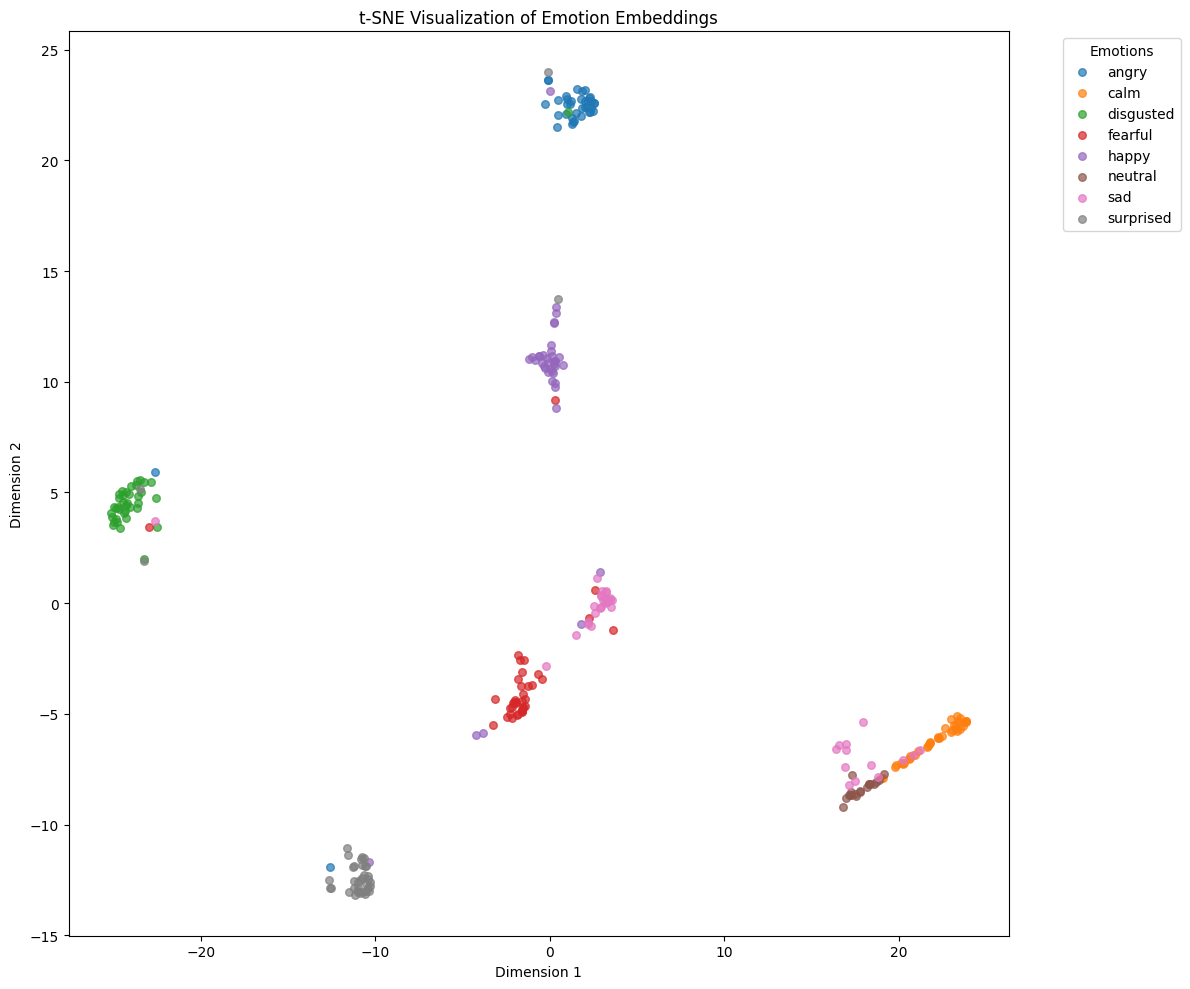

In [19]:
from sklearn.manifold import TSNE

def plot_tsne(model, test_loader, device, label_encoder):
    model.eval()

    # We need to hook into the model to get the "pooled" features
    # (the layer BEFORE the final classifier)
    features = []
    labels_list = []

    # Hook function to capture inputs to the classifier
    def get_features_hook(module, input, output):
        # input[0] is the pooled 128-dim vector
        features.append(input[0].cpu().numpy())

    # Register the hook on the classifier layer
    handle = model.classifier.register_forward_hook(get_features_hook)

    print("Extracting deep features for t-SNE (this takes time)...")

    with torch.no_grad():
        for batch in test_loader:
            input_values = batch['input_values'].to(device)
            if 'attention_mask' in batch:
                attention_mask = batch['attention_mask'].to(device)
            else:
                attention_mask = torch.ones_like(input_values).to(device)

            # This forward pass triggers the hook
            model(input_values, attention_mask)
            labels_list.extend(batch['labels'].cpu().numpy())

    # Remove hook
    handle.remove()

    # Flatten list of arrays
    features = np.concatenate(features, axis=0)
    labels = np.array(labels_list)

    # Run t-SNE
    print("Computing t-SNE projection (turning 128 dimensions into 2)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(12, 10))
    classes = label_encoder.classes_

    # Scatter plot for each class
    for i, class_name in enumerate(classes):
        indices = labels == i
        plt.scatter(features_2d[indices, 0], features_2d[indices, 1],
                    label=class_name, alpha=0.7, s=30)

    plt.legend(title="Emotions", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('t-SNE Visualization of Emotion Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.savefig('tsne_clusters.png', dpi=300)
    plt.show()

# Run it
plot_tsne(model, test_loader, device, label_encoder)